<a href="https://colab.research.google.com/github/HeegonJin/Texture_Segmentation/blob/main/DSP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# colab에서 cv2 버전 없그레이드 및 런타임 재시작 필수 !!
!pip install --upgrade opencv-python
!pip install --upgrade opencv-contrib-python
import cv2
from cv2 import dnn_superres 
# colab에서 cv2 버전 없그레이드 및 런타임 재시작 필수 !!

Requirement already up-to-date: opencv-python in /usr/local/lib/python3.6/dist-packages (4.4.0.46)
Requirement already up-to-date: opencv-contrib-python in /usr/local/lib/python3.6/dist-packages (4.4.0.46)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
import imageio
import matplotlib.pyplot as plt
from skimage.transform import rescale
from skimage.filters import gabor_kernel
from skimage.feature import canny 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def main(image_path, opt='fsrcnn', resize_size = 20.0, n_clusters=5, n_neighbors=81, pretrained_weight="/content/drive/MyDrive/FSRCNN_x2.pb"):
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  edge_removed_image, mask_indexes = edge_masking(image, resize_size)
  kernels = gabor_filter_bank()

  if opt == 'baseline':
    feats = compute_feats_baseline(image, kernels, 20.0)
    feats_stack = np.reshape(feats[1:-1, 1:-1,:], [(feats.shape[0]-2)*(feats.shape[1]-2), feats.shape[2]])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(feats_stack)
    cluster_texture = np.reshape(kmeans.labels_, [feats.shape[0]-2, feats.shape[1]-2])
    plt.imshow(cluster_texture)
    plt.show()
    return 

  if opt == 'pyramid':
    feats = compute_feats_opt1(edge_removed_image, kernels, 20.0)
    feats_stack = np.reshape(feats[1:-1, 1:-1,:], [(feats.shape[0]-2)*(feats.shape[1]-2), feats.shape[2]])

  elif opt == 'fsrcnn':
    sr = dnn_superres.DnnSuperResImpl_create()
    pretrained_weight = pretrained_weight
    sr.readModel(pretrained_weight)
    sr.setModel("fsrcnn", 2)
    edge_removed_image = np.float32(edge_removed_image) # upsampling needs dtype=np.float32
    feats = compute_feats_opt2(edge_removed_image, kernels, 20.0, sr)
    feats_stack = np.reshape(feats[1:-1, 1:-1,:], [(feats.shape[0]-2)*(feats.shape[1]-2), feats.shape[2]])
    feats_stack = np.float64(feats_stack) # revert dtype

  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(feats_stack)
  cluster_texture = np.reshape(kmeans.labels_, [feats.shape[0]-2, feats.shape[1]-2])
  cluster_result = knn_labeling(edge_removed_image, cluster_texture, mask_indexes, resize_size, n_neighbors)

  plt.imshow(cluster_result)
  plt.show()
  return 

In [ ]:
def edge_masking(image, resize_size=20.0):
  blur_image = cv2.medianBlur(image, ksize=5)
  canny = cv2.Canny(blur_image, 240, 255)
  mask_indexes = np.where(canny>0)
  image[mask_indexes] = 0 
  mask_rescale = rescale(canny,1/resize_size*2)[1:-1, 1:-1]
  mask_rescale_indexes = np.where(mask_rescale>0)

  return image, mask_rescale_indexes

In [ ]:
def knn_labeling(image, cluster_result, edge_indexes, resize_size=20.0, n_neighbors=81):
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(rescale(image, 1/resize_size*2)[1:-1, 1:-1], cluster_result)
  edge_nn = knn.predict(cluster_result)[edge_indexes[0], edge_indexes[1]]
  cluster_result[edge_indexes[0], edge_indexes[1]] = edge_nn

  return cluster_result

In [ ]:
 # prepare filter bank kernels
def gabor_filter_bank():
    kernels = []

    # Orientation
    for theta in range(4):
        theta = theta / 4. * np.pi

        # Sigma
        for sigma in (1, 6):

            # Frequency
            for frequency in (0.05, 0.25):
                kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
                # Stack the filters into the filter  bank
                kernels.append(kernel)
    return kernels

In [ ]:
# Feature Computation Function
def compute_feats_baseline(image, kernels, resize_size):
    feats = np.zeros((int(image.shape[0]//resize_size), int(image.shape[1]//resize_size), len(kernels)*2), dtype=np.double)

    # For multiple kernels,
    for k, kernel in enumerate(kernels):

        # Convolve the filters
        filtered = ndi.convolve(image, kernel, mode='wrap')

        # Grid-wise Average
        filtered_grid_avg = rescale(filtered, 1/resize_size)

        filtered_square_grid_avg = rescale(cv2.multiply(filtered, filtered), 1/resize_size) # Changed to Opencv operation to prevent underflow or overflow

        feats[:, :, 2*k] = filtered_grid_avg

        # Grid-wise Standard Deviation
        feats[:, :, 2*k + 1] = np.sqrt(cv2.subtract(filtered_square_grid_avg, cv2.multiply(filtered_grid_avg, filtered_grid_avg))) # Changed to Opencv operation to prevent underflow or overflow

    return feats

In [ ]:
# Feature Computation Function
def compute_feats_opt1(image, kernels, resize_size):
    feats = np.zeros((int(image.shape[0]//resize_size)*2, int(image.shape[1]//resize_size)*2, len(kernels)*2), dtype=np.double)

    # For multiple kernels,
    for k, kernel in enumerate(kernels):

        # Convolve the filters
        filtered = ndi.convolve(image, kernel, mode='wrap')
        # Apply Gaussian pyramid 
        filtered_upscale = cv2.pyrUp(filtered)
        # Grid-wise Average
        filtered_grid_avg = rescale(filtered_upscale, 1/(resize_size))
        filtered_square_grid_avg = rescale(filtered_upscale*filtered_upscale, 1/(resize_size))

        feats[:, :, 2*k] = filtered_grid_avg

        # Grid-wise Standard Deviation
        feats[:, :, 2*k + 1] = np.sqrt(filtered_square_grid_avg - filtered_grid_avg*filtered_grid_avg)
    return feats

In [ ]:
# Feature Computation Function
def compute_feats_opt2(image, kernels, resize_size, sr):

    feats = np.zeros((int(image.shape[0]//resize_size)*2, int(image.shape[1]//resize_size)*2, len(kernels)*2), dtype=np.double)

    # For multiple kernels,
    for k, kernel in enumerate(kernels):

        # Convolve the filters
        filtered = ndi.convolve(image, kernel, mode='wrap')
        # Grid-wise Average
        filtered_upscale = sr.upsample(filtered)
        filtered_grid_avg = rescale(filtered_upscale, 1/resize_size)
        filtered_square_grid_avg = rescale(cv2.multiply(filtered_upscale, filtered_upscale), 1/resize_size) # Changed to Opencv operation to prevent underflow or overflow

        feats[:, :, 2*k] = filtered_grid_avg

        # Grid-wise Standard Deviation
        feats[:, :, 2*k + 1] = np.sqrt(cv2.subtract(filtered_square_grid_avg, cv2.multiply(filtered_grid_avg, filtered_grid_avg))) # Changed to Opencv operation to prevent underflow or overflow
    return feats

In [ ]:
test_images = ['/content/drive/MyDrive/texture_images/texture_02.jpg', '/content/drive/MyDrive/texture_images/texture_03.jpg', '/content/drive/MyDrive/texture_images/texture_04.jpg']

/content/drive/MyDrive/texture_images/texture_02.jpg
original image


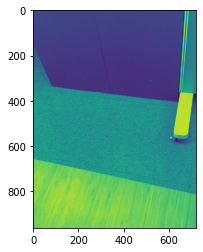

baseline


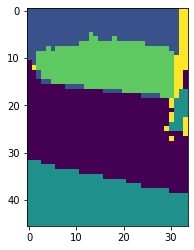

my solution


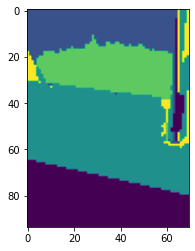

/content/drive/MyDrive/texture_images/texture_03.jpg
original image


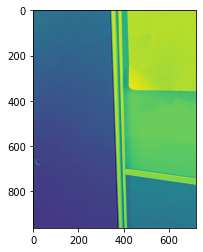

baseline


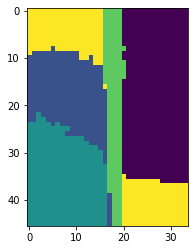

my solution


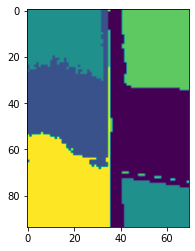

/content/drive/MyDrive/texture_images/texture_04.jpg
original image


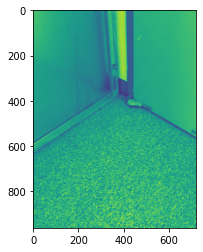

baseline


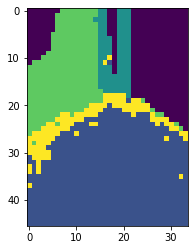

my solution


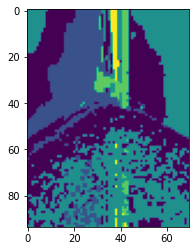

In [ ]:
for image in test_images:
  print(image)
  print('original image')
  plt.imshow(cv2.imread(image, cv2.IMREAD_GRAYSCALE))
  plt.show()
  print('baseline')
  main(image, 'baseline')
  print('my solution')
  main(image, pretrained_weight='/content/drive/MyDrive/FSRCNN_x2.pb')